In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
from utils import *

In [2]:
def my_best_wiener_filter(
    y: np.ndarray, h: np.ndarray, Sx: np.ndarray, Sv: np.ndarray
) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    G = np.conj(H) / (np.abs(H) ** 2 + Sv / Sx)
    X_hat = Y * G
    x_hat = np.abs(ifft2(X_hat))
    return x_hat


def my_wiener_filter(y: np.ndarray, h: np.ndarray, K: float) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    G = np.conj(H) / (np.abs(H) ** 2 + K)
    X_hat = Y * G
    x_hat = np.abs(ifft2(X_hat))
    return x_hat


def my_inverse_filter(y: np.ndarray, h: np.ndarray) -> np.ndarray:

    h /= np.sum(h)
    H = fft2(h, s=y.shape)
    Y = fft2(y)
    X_inv = Y / H
    x_inv = np.abs(ifft2(X_inv))
    return x_inv


def snr(restored, observed):
    signal_power = np.sum(np.abs(restored) ** 2)
    noise_power = np.sum(np.abs(restored - observed) ** 2)
    return signal_power / noise_power


def gradient_descent_optimize_K_SNR(y, h, K_init, lr, max_iters=100, tol=1e-5):

    K = K_init
    history = []

    for _ in range(max_iters):
        x_hat = my_wiener_filter(y, h, K)

        current_snr = snr(fft2(x_hat), fft2(y))
        history.append(current_snr)

        delta_K = 1e-5
        x_hat_plus = my_wiener_filter(y, h, K + delta_K)
        snr_plus = snr(fft2(x_hat_plus), fft2(y))

        K_new = K + lr * (snr_plus - current_snr) / delta_K

        if np.abs(K_new - K) < tol:
            break

        K = K_new

    return K, history

Optimized K: 0.06380253909856093


/tmp/ipykernel_71954/1294760788.py:8: RuntimeWarning: divide by zero encountered in divide
  G = np.conj(H) / (np.abs(H) ** 2 + Sv / Sx)


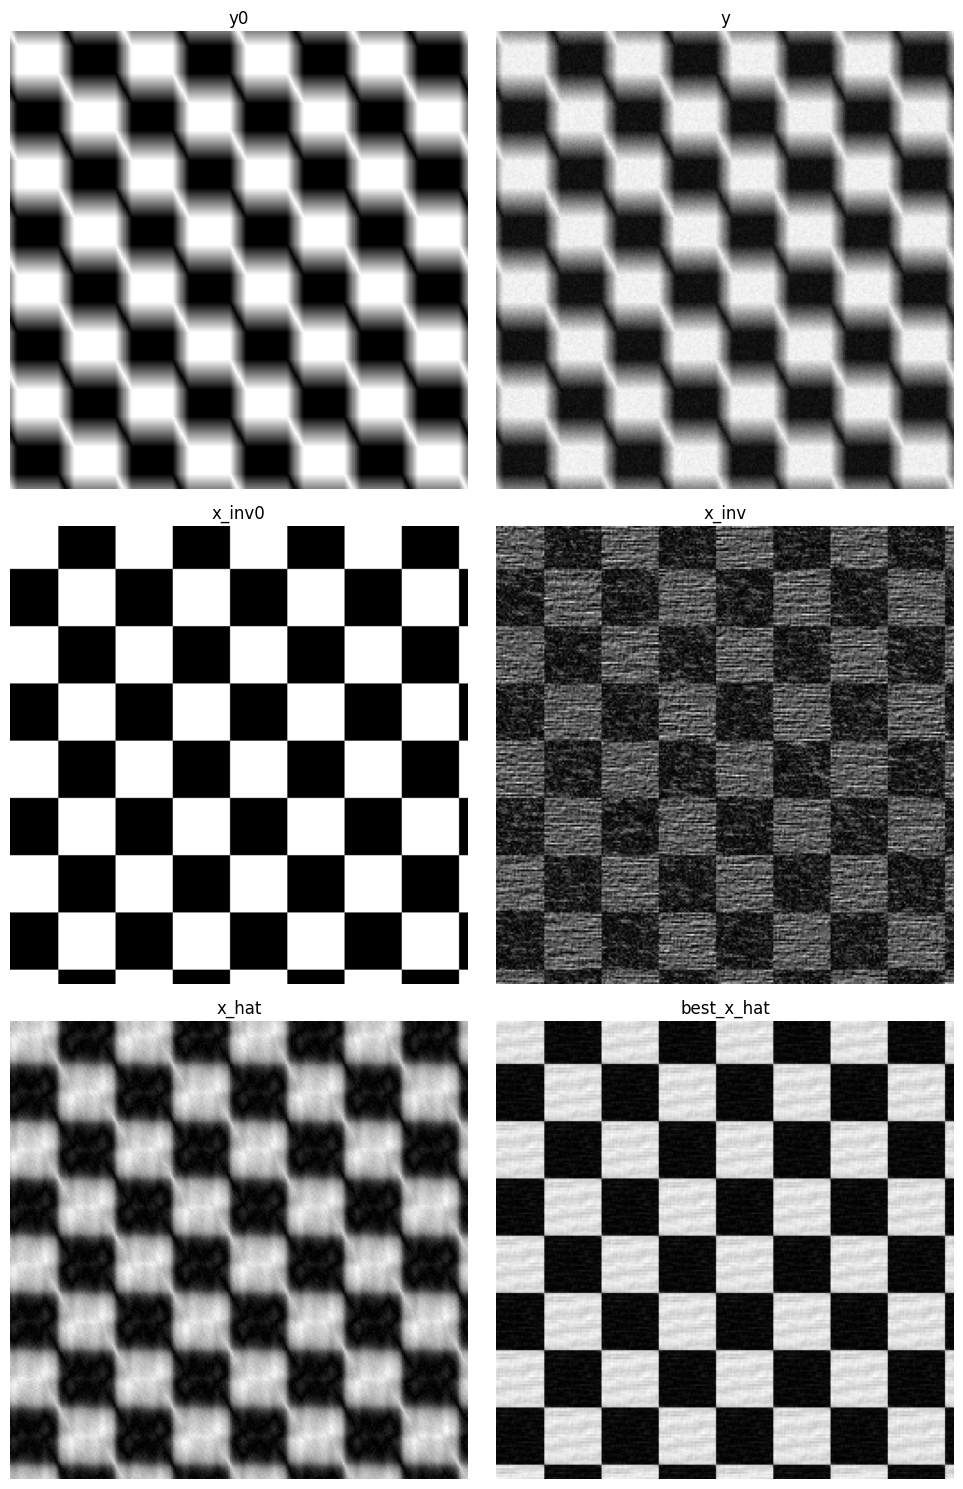

In [21]:
image_path = "data/checkerboard.tif"
x, y0, y, h, v = generate_noisy_image(
    image_path=image_path, noise_level=0.02, length=20, angle=30
)

K_init = 1e-3
lr = 1e-3
K_opt, snr_history = gradient_descent_optimize_K_SNR(y, h, K_init, lr)

print(f"Optimized K: {K_opt}")

Sx = np.abs(fft2(x)) ** 2
Sv = np.abs(fft2(v)) ** 2

x_inv0 = my_inverse_filter(y=y0, h=h)
x_inv = my_inverse_filter(y=y, h=h)
best_x_hat = my_best_wiener_filter(y=y, h=h, Sx=Sx, Sv=Sv)
x_hat = my_wiener_filter(y=y, h=h, K=K_opt)

images = [y0, y, x_inv0, x_inv, x_hat, best_x_hat]
titles = ["y0", "y", "x_inv0", "x_inv", "x_hat", "best_x_hat"]
show_images_grid(images, titles)

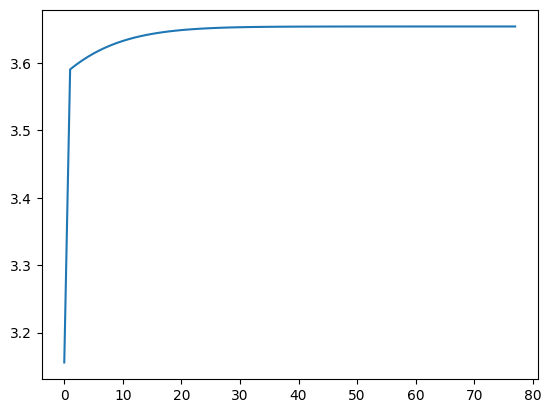

In [22]:
plt.plot(snr_history)